In [1]:
from simulator import Sim
from base_strategy import BaseStrategy

from stoikov_strategy import StoikovStrategy, FutureStrategy

from get_info import get_pnl
from load_data import load_md_from_file


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

PATH_TO_FILE = '../md/btcusdt:Binance:LinearPerpetual/'
T = pd.Timedelta(2, 'h').delta

In [2]:
from load_data import load_before_time

In [3]:
lobs = load_before_time(PATH_TO_FILE + 'lobs.csv', T)

names = lobs.columns.values
ln = len('btcusdt:Binance:LinearPerpetual_')
renamer = { name:name[ln:] for name in names[2:]}
renamer[' exchange_ts'] = 'exchange_ts'
lobs.rename(renamer, axis=1, inplace=True)

In [4]:
lobs = lobs[['receive_ts', 'ask_price_0', 'ask_vol_0', 'bid_price_0', 'bid_vol_0']]

In [5]:
lobs = lobs.rename(mapper={col:col[:-2] for col in lobs.columns if col[-1] == '0'}, axis=1)

In [6]:
lobs

,receive_ts,ask_price,ask_vol,bid_price,bid_vol
0,1655942402250125991,19977.5,0.079,19977.4,12.381
1,1655942402657844605,19977.5,0.078,19977.4,12.381
2,1655942403346968722,19977.5,0.079,19977.4,12.381
3,1655942404080791047,19977.5,0.079,19977.4,12.381
4,1655942404452706766,19977.5,0.079,19977.4,12.381
...,...,...,...,...,...
206519,1655949602089731797,20367.0,2.467,20366.9,2.101
206520,1655949602122549162,20367.0,1.459,20366.9,2.391
206521,1655949602157709637,20367.0,1.383,20366.9,3.089
206522,1655949602189840336,20367.0,1.486,20366.9,2.442


In [7]:
lobs['mid_price'] = 0.5 * (lobs['ask_price'] + lobs['bid_price'])
lobs['spread'] = (lobs['ask_price'] - lobs['bid_price'])
lobs['imbalance'] = lobs['bid_vol'] / (lobs['bid_vol'] + lobs['ask_vol']) 

In [8]:
I = lobs['imbalance'].values

In [9]:
n = 21
I_unique = list(range(0, n))

I = (I * n).astype(int)

In [10]:
I_unique

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [11]:
I

array([20, 20, 20, ..., 14, 13, 12])

In [12]:
spread = np.round_(lobs['spread'].values, 4)
max_spread = np.quantile(spread, 0.99)
min_spread = np.min(spread)

S = (np.clip(spread, 0, max_spread) / min_spread).astype(int)

S_unique = sorted(set(S))

In [13]:
print(*sorted(set(S)), sep='  ')

1  2  4  5  6  8  9  10  11  13  15  16  17  18


In [14]:
dM = np.diff(lobs['mid_price'].values)
dM = np.round_(dM, 2)

alpha = 0.01
q1 = np.quantile(dM[dM != 0], alpha)
q2 = np.quantile(dM[dM != 0], 1 - alpha)

q = max(abs(q1), abs(q2))
q1, q2 = -q, q

dM = np.clip(dM, q1, q2)

In [15]:
print(*sorted(set(dM)), sep='  ')

-3.8  -3.75  -3.7  -3.65  -3.6  -3.55  -3.5  -3.45  -3.4  -3.35  -3.3  -3.25  -3.2  -3.15  -3.1  -3.05  -3.0  -2.95  -2.9  -2.85  -2.8  -2.75  -2.7  -2.65  -2.6  -2.55  -2.5  -2.45  -2.4  -2.35  -2.3  -2.25  -2.2  -2.15  -2.1  -2.05  -2.0  -1.95  -1.9  -1.85  -1.8  -1.75  -1.7  -1.65  -1.6  -1.55  -1.5  -1.45  -1.4  -1.35  -1.3  -1.25  -1.2  -1.15  -1.1  -1.05  -1.0  -0.95  -0.9  -0.85  -0.8  -0.75  -0.7  -0.65  -0.6  -0.55  -0.5  -0.45  -0.4  -0.35  -0.3  -0.25  -0.2  -0.15  -0.1  -0.05  0.0  0.05  0.1  0.15  0.2  0.25  0.3  0.35  0.4  0.45  0.5  0.55  0.6  0.65  0.7  0.75  0.8  0.85  0.9  0.95  1.0  1.05  1.1  1.15  1.2  1.25  1.3  1.35  1.4  1.45  1.5  1.55  1.6  1.65  1.7  1.75  1.8  1.85  1.9  1.95  2.0  2.05  2.1  2.15  2.2  2.25  2.3  2.35  2.4  2.45  2.5  2.55  2.6  2.65  2.7  2.75  2.8  2.85  2.9  2.95  3.0  3.05  3.1  3.15  3.2  3.25  3.3  3.35  3.4  3.45  3.5  3.55  3.6  3.65  3.7  3.75  3.8


In [16]:
k = round((q2 - q1) / (0.05)) + 1

In [17]:
dM_unique = np.round(np.linspace(q1, q2, k), 2)

In [18]:
dM_unique

array([-3.8 , -3.75, -3.7 , -3.65, -3.6 , -3.55, -3.5 , -3.45, -3.4 ,
       -3.35, -3.3 , -3.25, -3.2 , -3.15, -3.1 , -3.05, -3.  , -2.95,
       -2.9 , -2.85, -2.8 , -2.75, -2.7 , -2.65, -2.6 , -2.55, -2.5 ,
       -2.45, -2.4 , -2.35, -2.3 , -2.25, -2.2 , -2.15, -2.1 , -2.05,
       -2.  , -1.95, -1.9 , -1.85, -1.8 , -1.75, -1.7 , -1.65, -1.6 ,
       -1.55, -1.5 , -1.45, -1.4 , -1.35, -1.3 , -1.25, -1.2 , -1.15,
       -1.1 , -1.05, -1.  , -0.95, -0.9 , -0.85, -0.8 , -0.75, -0.7 ,
       -0.65, -0.6 , -0.55, -0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25,
       -0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,
        0.25,  0.3 ,  0.35,  0.4 ,  0.45,  0.5 ,  0.55,  0.6 ,  0.65,
        0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,  0.95,  1.  ,  1.05,  1.1 ,
        1.15,  1.2 ,  1.25,  1.3 ,  1.35,  1.4 ,  1.45,  1.5 ,  1.55,
        1.6 ,  1.65,  1.7 ,  1.75,  1.8 ,  1.85,  1.9 ,  1.95,  2.  ,
        2.05,  2.1 ,  2.15,  2.2 ,  2.25,  2.3 ,  2.35,  2.4 ,  2.45,
        2.5 ,  2.55,

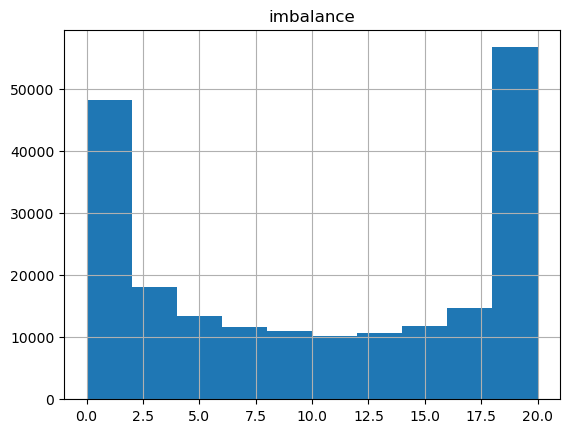

In [19]:
plt.title("imbalance")
plt.hist(I)
plt.grid()
plt.show()

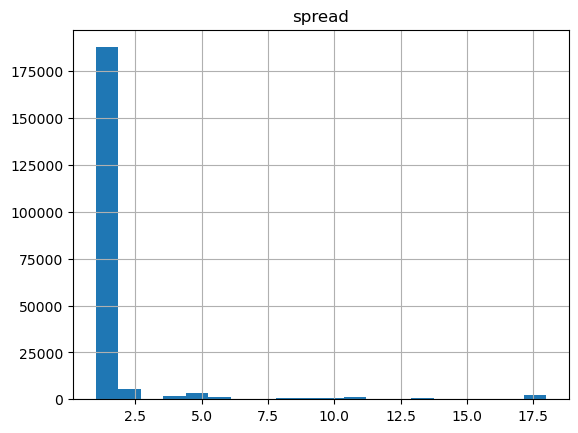

In [20]:
plt.title("spread")
plt.hist(S, bins=20)
plt.grid()
plt.show()

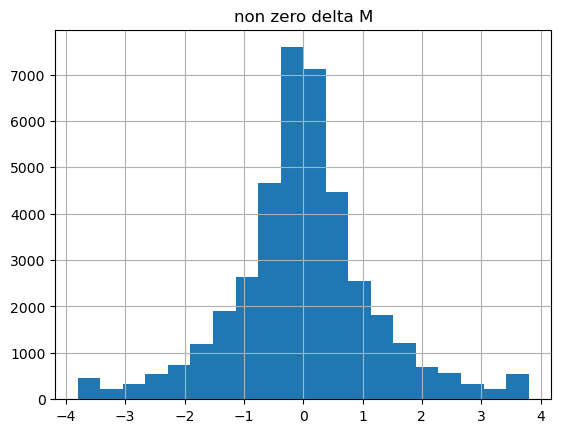

In [21]:
plt.title("non zero delta M")
plt.hist(dM[dM != 0], bins=20)
plt.grid()
plt.show()

In [22]:
n = len(I_unique)
m = len(S_unique)

k = len(dM_unique)

In [23]:
n, m, k

(21, 14, 153)

In [24]:
a = np.ones((n * m, n * m))

In [25]:
I_map = dict( zip( I_unique, range(len(I_unique)) ) )

S_map = dict( zip( S_unique, range(len(S_unique)) ) )

dM_map = dict( zip( dM_unique, range(len(dM_unique)) ) )

In [46]:
R = np.zeros((n * m , k))
T = np.zeros((n * m , n * m))
Q = np.zeros((n * m , n * m))

cont = np.zeros((n * m, 1))

In [47]:
N = len(dM)

In [48]:
for idx in range(N):
    
    i, i_ = I[idx], I[idx + 1]
    s, s_ = S[idx], S[idx + 1]
    dm = dM[idx]
    
    x = I_map[i] * m +  S_map[s]
    y = I_map[i_] * m + S_map[s_]
    cont[x] += 1
    j = dM_map[dm]
    if dm != 0.0:
        R[x, j] += 1
        T[x, y] += 1
    else:
        Q[x, y] += 1

    #Symmetrize the data
    i, i_ = n - 1 - I[idx], n - 1 - I[idx + 1]
    dm = -dM[idx]
    
    x = I_map[i] * m +  S_map[s]
    y = I_map[i_] * m + S_map[s_]
    cont[x] += 1
    j = dM_map[dm]
    if dm != 0.0:
        R[x, j] += 1
        T[x, y] += 1
    else:
        Q[x, y] += 1

In [49]:
R = R / (cont + 1e-10)

Q = Q / (cont + 1e-10)

T = T / (cont + 1e-10)

$Q + T$ должна быть стохастической матрицей. Сумма по столбцам иногда даёт ноль, это происходит для тех x, которые ни разу не встречались.

In [50]:
arr = np.sum(Q + T, axis=1)

In [51]:
set(np.round(arr, 4))

{1.0}

In [52]:
Q_inv = np.linalg.inv(np.eye(n * m) - Q)

In [53]:
G = Q_inv @ (R @ dM_unique)

In [54]:
B = Q_inv @ T

In [55]:
n_iter = 100

In [56]:
G_star = G
for i in range(n_iter):
    G_star_new = G + B @ G_star
    err = np.linalg.norm(G_star_new - G_star)
    G_star = G_star_new
    print(err)

2.255064727460277
0.895771957793771
0.3393989525330416
0.12624578922253252
0.04683251301260214
0.01736387851963297
0.006436943167196324
0.0023861639344966313
0.000884542780727236
0.00032789672673082894
0.00012155008204669131
4.5058156993735945e-05
1.6702888870630986e-05
6.1916979195740665e-06
2.295239071220166e-06
8.508364689032853e-07
3.1540187076036563e-07
1.1691828434515375e-07
4.334116701713015e-08
1.6066407301061526e-08
5.955756591805456e-09
2.207776660066264e-09
8.184143682777875e-10
3.033830859012495e-10
1.124628656772175e-10
4.168974610870634e-11
1.5454308037530853e-11
5.728640341183728e-12
2.123671283534762e-12
7.871487377094173e-13
2.919811603011685e-13
1.0805133067444379e-13
4.028727470147267e-14
1.4945749670437927e-14
5.900093770701101e-15
2.6649151312618923e-15
1.8659986528212405e-15
2.236568962669116e-15
2.0244819389381433e-15
1.9215450131023856e-15
1.6702317023132179e-15
1.750311630263906e-15
1.7226424698042253e-15
1.6778522151821474e-15
1.5691031338738782e-15
1.52988793

Видно, что ряд быстро сходится

In [57]:
G_star

array([-1.18014901e+00, -9.47420089e-01, -1.12357140e+00, -1.12997593e+00,
       -1.11627330e+00, -9.58705400e-01, -8.75704069e-01, -1.15669099e+00,
       -9.44047092e-01, -1.02604472e+00, -7.87898525e-01, -9.07470856e-01,
       -1.03306439e+00, -8.34264714e-01, -9.04822032e-01, -6.35298215e-01,
       -5.06664549e-01, -7.46502388e-01, -7.89100456e-01, -6.26617517e-01,
       -6.62113528e-01, -6.27302751e-01, -7.96854394e-01, -7.52322114e-01,
       -6.83502077e-01, -5.65462945e-01, -1.02170891e-01, -5.31160457e-01,
       -7.43870375e-01, -5.17851868e-01, -4.81754615e-01, -4.17784593e-01,
       -3.99324126e-01, -3.70939694e-01, -6.36822557e-01, -3.52546892e-01,
       -5.31538973e-01, -3.78813839e-01, -4.76442256e-01, -1.03973645e+00,
       -5.57518329e-01, -3.74444141e-01, -6.29094742e-01, -2.67311455e-01,
       -3.18767736e-01, -3.38529778e-01, -1.66890769e-01, -1.97066001e-01,
       -3.28178295e-01, -3.25123339e-01, -4.97344298e-01, -1.09385101e-01,
       -6.44515132e-01, -

In [58]:
G_spread = {}
for s in S_unique:
    G_spread[s] = []
    for i in I_unique:
        x = I_map[i] * m +  S_map[s]
        G_spread[s].append( G_star[x] )

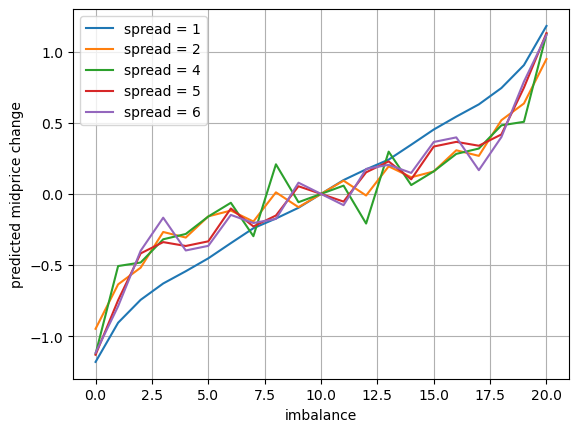

In [62]:
for s in S_unique[:5]:
    plt.plot(I_unique, G_spread[s], label=f'spread = {s}')
plt.grid()
plt.legend()
plt.xlabel("imbalance")
plt.ylabel('predicted midprice change')
plt.show()